# Node Classification on Knowledge Graphs

This is the implementation for one of the optional exercices proposed on ...(add reference).

## Setup

In [2]:
# # Check CUDA Version
# !python -c "import torch; print(torch.version.cuda)"

# # Install Pytorch Geometric
# !pip install -q torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
# !pip install -q torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
# !pip install -q git+https://github.com/rusty1s/pytorch_geometric.git
# !pip install moviepy

In [41]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn.functional as F
from IPython.display import Image
from moviepy.editor import ImageSequenceClip
from sklearn.manifold import TSNE
from torch.nn import Linear
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import NormalizeFeatures


torch.manual_seed(42)
warnings.filterwarnings("ignore", category=FutureWarning)

print(f"torch: {torch.__version__}")

torch: 1.8.1


## Knowledge Graphs and Node Classification

Some common caracteristics of knowledge graph datasets:

- Only one large graph and not many individual graphs (like molecules).
- Unlabeled nodes are infered performing node-level predictions.

## Dataset Introduction

We will use Cora to showcase the use of binary mask for node-level prediciton.

### What is the Cora Dataset
The Cora dataset consists of 2708 scientific publications classified into one of seven classes. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words("bag of words" vocabulary).

- Nodes: Publications (Papers, Books ...)
- Edges: Citations
- Node Features: word vectors 
- Labels: Seven pubilcation types (Neural_Networks, Reinforcement_Learning, ...)

We normalize the features using torch geometric's transform functions.

In [4]:
dataset = Planetoid(root="data/Planetoid", name="Cora", transform=NormalizeFeatures())

### Explore Dataset

In [5]:
# Get some basic info about the dataset
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features:,}")
print(f"Number of classes: {dataset.num_classes}")
print(50 * "=")

# There is only one graph in the dataset, use it as new data object
data = dataset[0]

# Gather some statistics about the graph.
print(data)
print(f"Number of nodes: {data.num_nodes:,}")
print(f"Number of edges: {data.num_edges:,}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}")
print(f"Is undirected: {data.is_undirected()}")


Number of graphs: 1
Number of features: 1,433
Number of classes: 7
Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2,708
Number of edges: 10,556
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True


Observations:

- We have 5% of training nodes that a relative small set of training set. 
- Only 20 nodes per labeled class.

In [6]:
print(f"#Nodes x Features: {data.x.shape}")
data.x[1][:50]

#Nodes x Features: torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0435, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

### Why do we even use the graph structure - aren't the features enough?

Apparently, simple MLP models perform a lot worse than GNNs on this type of task, as the citation information is crucial for a correct classification.

### How do the labels look like?

Encoded values between 0-6.

In [7]:
data.y.unique()


tensor([0, 1, 2, 3, 4, 5, 6])

### Binary Mask

In [8]:
print(len(data.test_mask) == data.num_nodes)
data.test_mask

True


tensor([False, False, False,  ...,  True,  True,  True])

## Edge connections

In [9]:
data.edge_index.t()

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

## Model

In [10]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = F.softmax(self.out(x), dim=1)
        return x
model = GCN(hidden_channels=16)
model

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)

Observations:
- Dropout is only applied to the training steps and not for predictions.
- We have 2 message passing layers and one linear output layer.
- We use the softmax function for the classification problem
- The output of the model are 7 probabilities.

## Training

In [11]:
!nvidia-smi

Mon Apr 26 18:34:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000001:00:00.0 Off |                    0 |
| N/A   49C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Is CUDA available: {torch.cuda.is_available()}")
device

Is CUDA available: True


device(type='cuda', index=0)

In [13]:
model = GCN(hidden_channels=16)
model = model.to(device)
data = data.to(device)

In [14]:
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=decay
)

In [15]:
criterion = torch.nn.CrossEntropyLoss()

In [16]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

In [17]:
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

In [18]:
losses = []
for epoch in range(0, 1001):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

Epoch: 000, Loss: 1.9461
Epoch: 100, Loss: 1.8379
Epoch: 200, Loss: 1.7439
Epoch: 300, Loss: 1.6316
Epoch: 400, Loss: 1.5225
Epoch: 500, Loss: 1.4232
Epoch: 600, Loss: 1.3858
Epoch: 700, Loss: 1.3155
Epoch: 800, Loss: 1.3713
Epoch: 900, Loss: 1.3519
Epoch: 1000, Loss: 1.3210


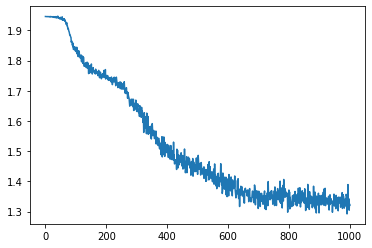

In [30]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)

## Calculate test metric

In [31]:
test_acc = test()
print(f"test accuracy: {test_acc}")

test accuracy: 0.686


torch.Size([2708, 7])


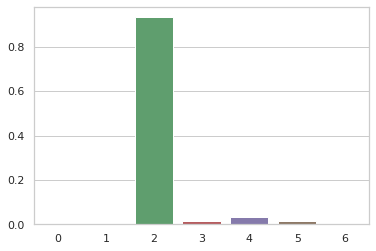

In [34]:
sample = 9
sns.set_theme(style="whitegrid")
print(model(data.x, data.edge_index).shape)
pred = model(data.x, data.edge_index)
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy());

## Visualizing the embeddings

In [38]:
def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.fromstring(rgb_str, dtype=np.uint8, sep='').reshape((w,h,-1))
    return rgba_arr


def visualize(h, color, epoch):
    fig = plt.figure(figsize=(5,5), frameon=False)
    fig.suptitle(f'Epoch = {epoch}')
    # Fit TSNE with 2 components
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    # Create scatterplot from embeddings
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], 
                z[:, 1], 
                s=70, 
                c=color.detach().cpu().numpy(), 
                cmap="Set2")
    fig.canvas.draw()

    # Convert to numpy
    return plt2arr(fig)


# Reset the previously trained model weights
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

TSNE Visualization finished.


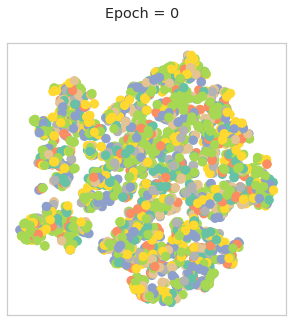

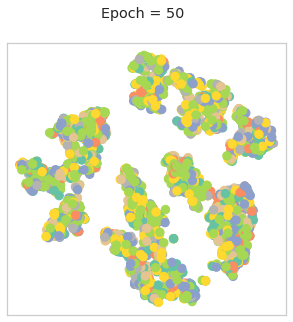

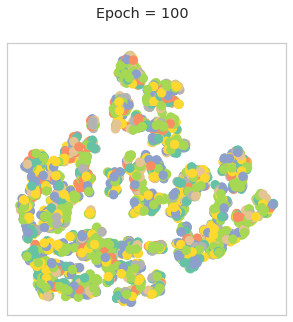

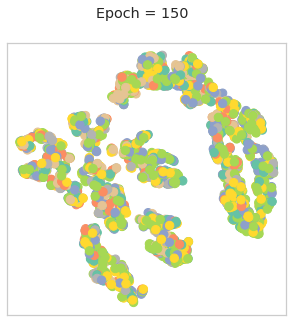

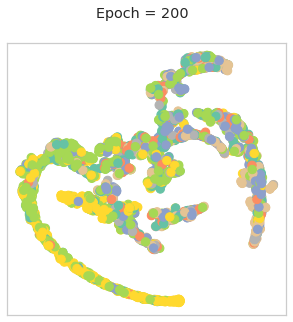

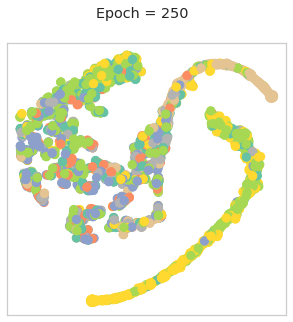

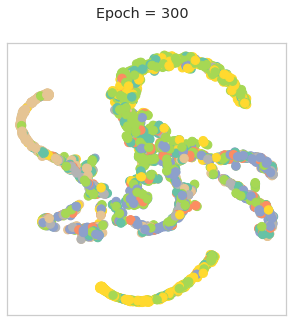

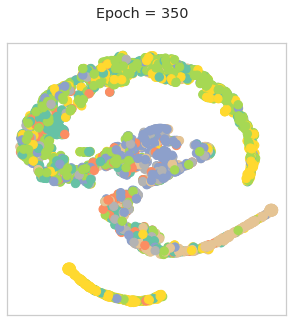

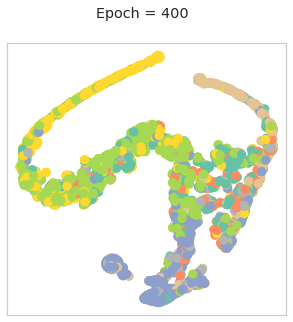

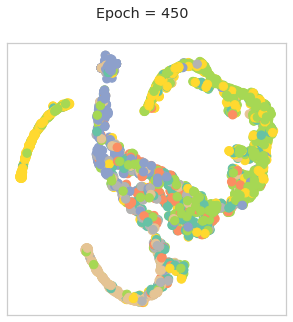

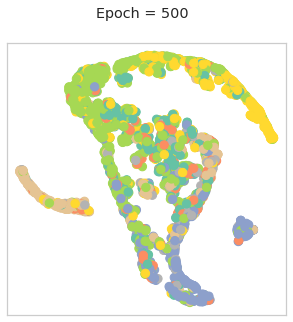

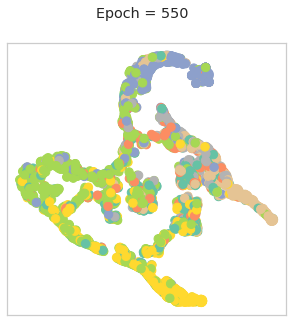

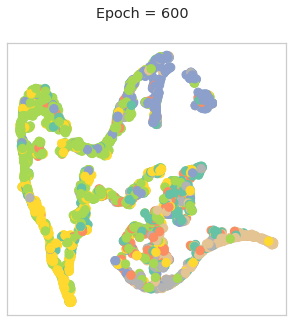

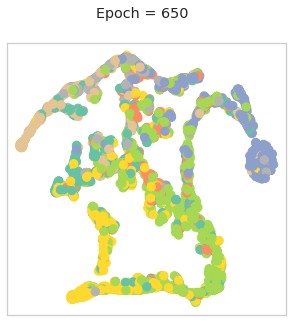

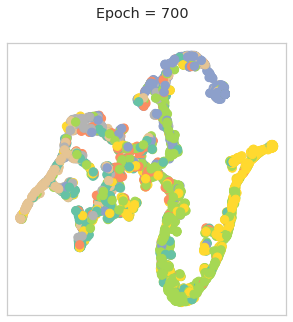

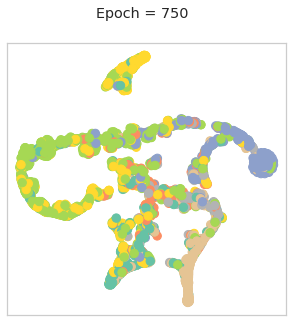

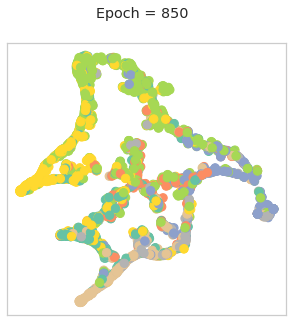

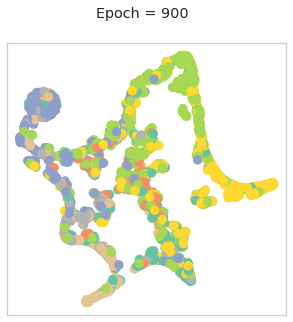

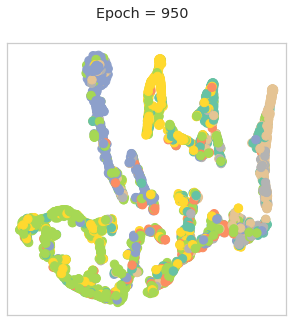

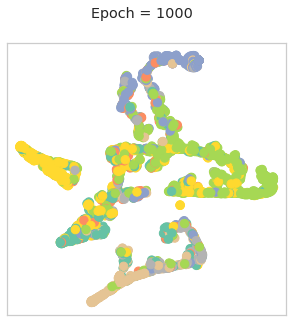

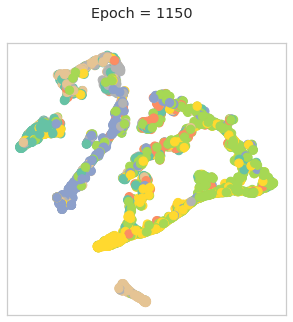

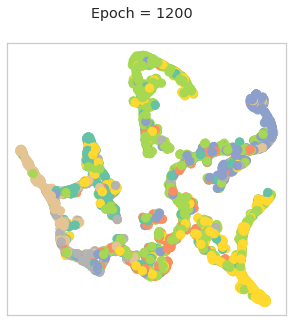

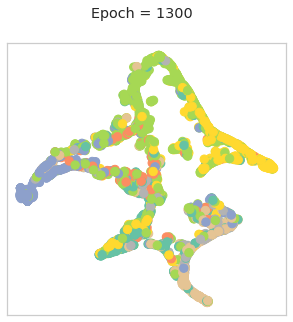

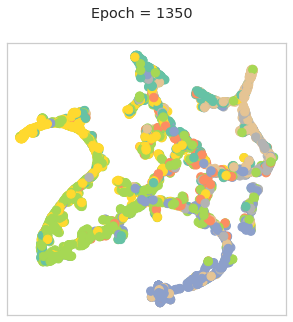

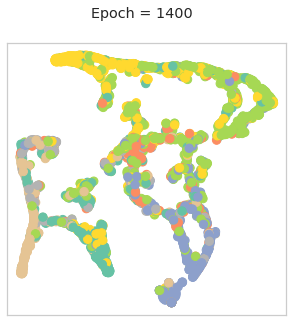

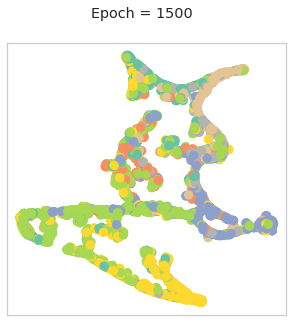

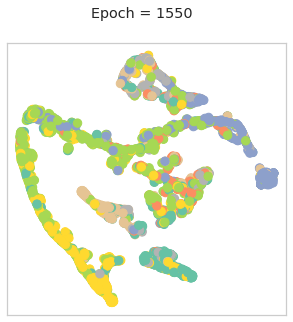

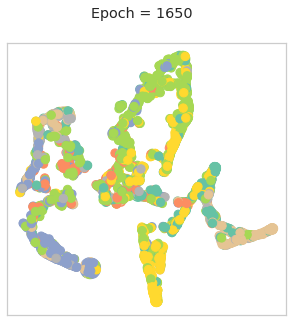

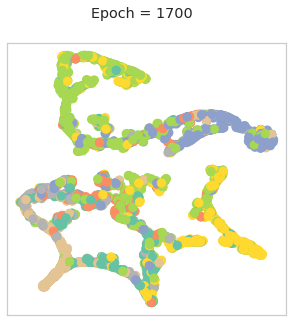

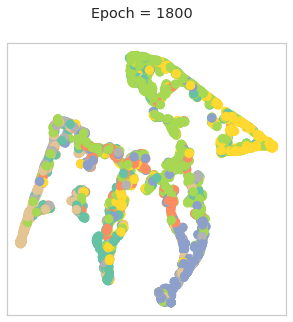

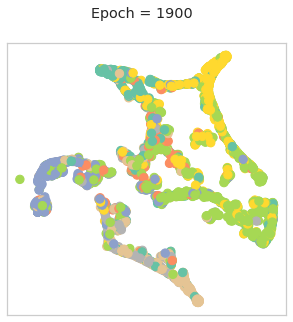

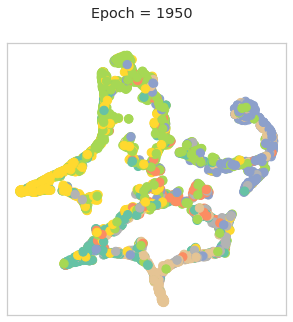

In [39]:
# Train the model and save visualizations
images = []
for epoch in range(0, 2000):
    loss = train()
    if epoch % 50 == 0:
      out = model(data.x, data.edge_index)
      images.append(visualize(out, color=data.y, epoch=epoch))
print("TSNE Visualization finished.")

In [44]:
fps = 1
filename = "/tmp/embeddings.gif"
clip = ImageSequenceClip(images, fps=fps)
clip.write_gif(filename, fps=fps)

t:  12%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 5/40 [00:00<00:00, 45.68it/s, now=None]

MoviePy - Building file /tmp/embeddings.gif with imageio.


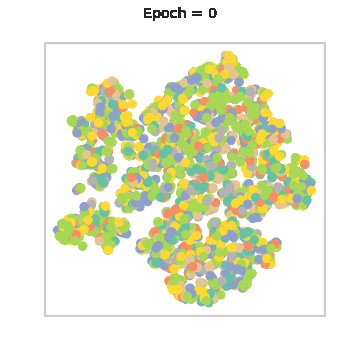

In [45]:
with open('/tmp/embeddings.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

## Future work
- Cross-Validation
- Hyperparameter Optimization
- Different layer types GCN, GAT... ([here](hhttps://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html))
- Including edge features ([here](https://wiki.tum.de/display/dlma/Exploiting+Edge+Features+in+Graph+Neural+Networks))  
- The best performance is currently [at around 0.9](https://paperswithcode.com/sota/node-classification-on-cora)